In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True) 

100%|██████████| 9912422/9912422 [00:08<00:00, 1189773.42it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 3209997.98it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1173879.95it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4557542.77it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [6]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [8]:
# model = Autoencoder()
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [9]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0487
Epoch:2, Loss:0.0434
Epoch:3, Loss:0.0450
Epoch:4, Loss:0.0363
Epoch:5, Loss:0.0376
Epoch:6, Loss:0.0413
Epoch:7, Loss:0.0403
Epoch:8, Loss:0.0348
Epoch:9, Loss:0.0338
Epoch:10, Loss:0.0338


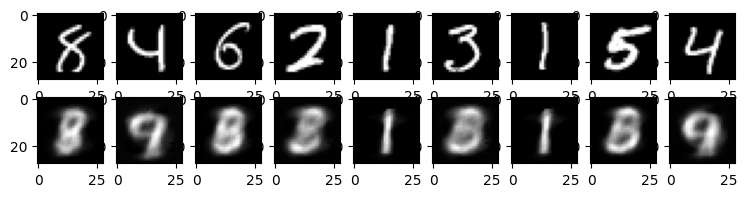

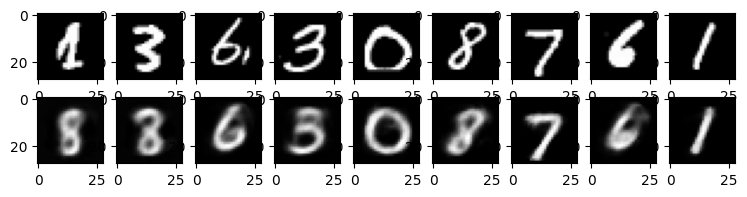

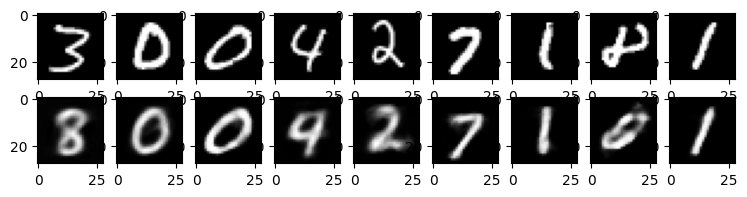

In [10]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

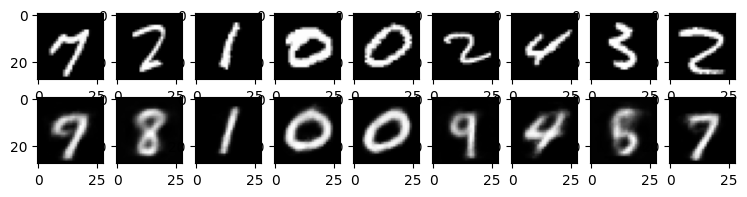

In [12]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img2 = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        pred = model(img2)
        recon = pred[0].detach().numpy()
        recon2 = recon.reshape(-1, 28,28) # -> use for Autoencoder_Linear

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon2[0])

#Práctica 2

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(32),
            nn.Linear(32, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


model = Autoencoder()

criterion = nn.BCELoss()
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [24]:

def entrenar(model, optimizer, criterion):
    num_epochs = 15
    for epoch in range(num_epochs):
        for (img, _) in train_loader:
            img = img.view(-1, 28*28)  # Aplanar la imagen
            noisy_img = add_noise(img)
            recon = model(noisy_img)

            loss = criterion(recon, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')


    n = 9
    plt.figure(figsize=(20, 6))
    for i in range(n):
        #originales
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(img[i].view(28, 28).detach().numpy(), cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Original")

        #imágenes con ruido
        ax = plt.subplot(3, n, i + n + 1)
        plt.imshow(noisy_img[i].view(28, 28).detach().numpy(), cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Con ruido")

        #imágenes reconstruidas
        ax = plt.subplot(3, n, i + 2 * n + 1)
        plt.imshow(recon[i].view(28, 28).detach().numpy(), cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruida")

    plt.show()


Epoch: 1, Loss: 0.1611
Epoch: 2, Loss: 0.1664
Epoch: 3, Loss: 0.1635
Epoch: 4, Loss: 0.1726
Epoch: 5, Loss: 0.1708
Epoch: 6, Loss: 0.1611
Epoch: 7, Loss: 0.1695
Epoch: 8, Loss: 0.1723
Epoch: 9, Loss: 0.1667
Epoch: 10, Loss: 0.1768
Epoch: 11, Loss: 0.1660
Epoch: 12, Loss: 0.1786
Epoch: 13, Loss: 0.1757
Epoch: 14, Loss: 0.1700
Epoch: 15, Loss: 0.1556


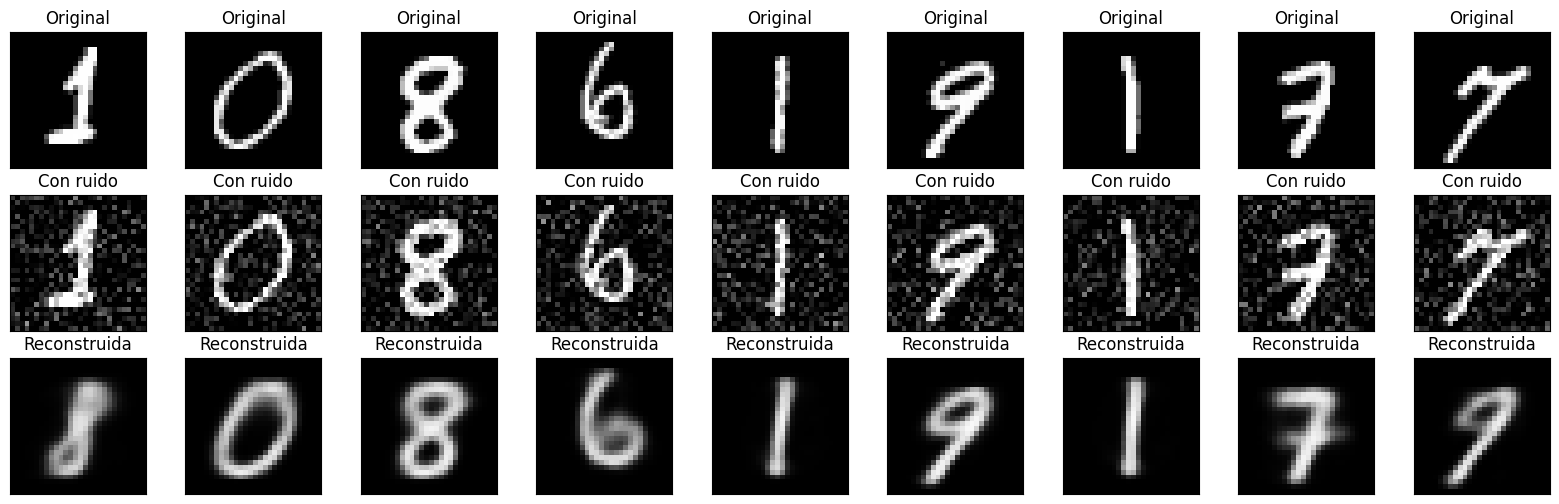

In [29]:
entrenar(model, optimizer, criterion)